# Loading model

In [1]:
import torch
from qwerty_qwen2_update import QwertyQwen2ForCausalLM
from transformers import Qwen2ForCausalLM, Qwen2Tokenizer, CLIPImageProcessor, Trainer
from typing import Dict, Sequence
import os
import conversation 
from PIL import Image

device = 'cuda:2'
model_name_or_path: str = "/data/uchiha_ssd2/fengqi/241121_qwerty/251124_230127/"
vision_tower_name_or_path: str = "openai/clip-vit-large-patch14-336"

model = QwertyQwen2ForCausalLM.from_pretrained(
    model_name_or_path,
    torch_dtype=torch.bfloat16,
    )
model.to(device)
model.config.use_cache = True
tokenizer = Qwen2Tokenizer.from_pretrained(model_name_or_path)
image_processor = CLIPImageProcessor.from_pretrained(vision_tower_name_or_path)

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

# Loading weights

In [2]:
from safetensors import safe_open
folder_path = model_name_or_path
merged_weights: Dict[str, torch.Tensor] = {}
safetensors_files = [
    f for f in os.listdir(folder_path) 
    if f.endswith('.safetensors')
]

for file_name in safetensors_files:
    file_path = os.path.join(folder_path, file_name)
    with safe_open(file_path, framework="pt", device="cpu") as f:
        keys = f.keys()
        
        for key in keys:
            if key in merged_weights:
                print(f"警告: 键 {key} 在多个文件中出现,将使用文件 {file_name} 中的值")
            tensor = f.get_tensor(key)
            merged_weights[key] = tensor

for key in model.state_dict().keys():
    if key.startswith('vision_model'):
        print(key)
        assert model.state_dict()[key].shape == merged_weights['model.' + key].shape, "未能正确加载模型参数"
        model.load_state_dict({
            **model.state_dict(),
            **{key: merged_weights['model.' + key] for key in merged_weights}
        }, strict=False)
        #model.state_dict()[key] = merged_weights['model.' + key] 据说，直接修改 state_dict() 中的值通常是不被推荐的操作，因为 state_dict() 是一个浅拷贝，而不是模型参数的直接映射。这种操作可能会导致模型参数与优化器不匹配。
    if key.startswith('mm_projector'):
        print(key)
        assert model.state_dict()[key].shape == merged_weights['model.' + key].shape, "未能正确加载模型参数"
        model.load_state_dict({
            **model.state_dict(),
            **{key: merged_weights['model.' + key] for key in merged_weights}
        }, strict=False)
        
missing_keys, unexpected_keys = model.load_state_dict({
    **model.state_dict(),
    **{key: merged_weights[key] for key in merged_weights}
}, strict=False)
print(f"Missing keys: {missing_keys}")
print(f"Unexpected keys: {unexpected_keys}")

Missing keys: []
Unexpected keys: []


In [3]:
def response(image_path:str,prompt :str) -> None:
    cur_conv = conversation.conv_qwen2_5.copy()
    cur_image = Image.open(image_path)
    image = image_processor(cur_image, return_tensors='pt')['pixel_values']
    cur_conv.append_message(['USER',(prompt,cur_image)])
    text = cur_conv.get_prompt()
    text += "\n<|im_start|>assistant\n"
    input_ids = tokenizer(text,return_tensors="pt",add_special_tokens=False)['input_ids'][0]
    input_ids = input_ids.unsqueeze(0)
    attention_mask = torch.ones_like(input_ids)
    labels = torch.arange(input_ids.shape[-1]).unsqueeze(0)

    image = image.to(device)
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    labels = labels.to(device)
    output_ids = model.generate(
        inputs=input_ids,                  # 输入 tokens
        max_length=1024,                      
        num_return_sequences=1,             # 返回生成的序列数
        temperature=0.7,                    # 控制生成的多样性
        top_k=50,                           # 限制最高概率的 K 个标记
        top_p=0.95,                         # 过滤累积概率小于 P 的标记
        do_sample=True,                     # 使用采样生成（而非贪心算法）
        images=image,
        attention_mask=attention_mask,
        labels=labels,
        use_cache=True,
    )
    generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    print(f"Generated text:\n\n{generated_text}")

# Imgae 3

In [16]:
image_path:str = "test_images/3.N.jpg"

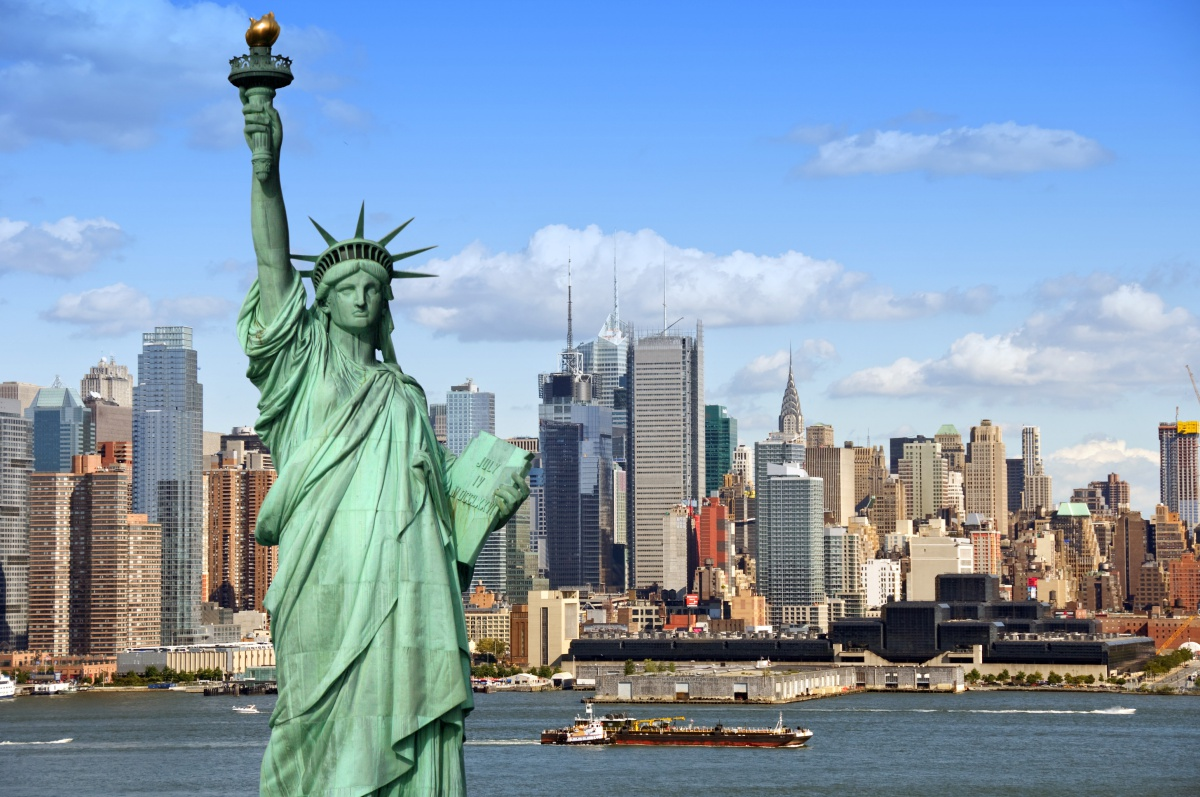

In [17]:
image = Image.open(image_path)
image

In [18]:
prompt :str = "<image>\nDescribe this picture concisely."

In [19]:
response(image_path,prompt)

Generated text:

The image features the iconic Statue of Liberty Liberty Liberty, a Liberty Bell holds a statue of Liberty stands proudly in New York is depicted stands tall is captured within a torch, glowing Island is prominently near a torch, New York is standing proudly, New York, facing in the city, New York Harbor, New York's great, New York City is the is proudly held high her her the Harbor Harbor City, surrounded Columbia Harbor, with extended high high in Upper, New York, with extended high in a City, with her her torch, with extended high in a city skyline, New York, offers a great, offering a large, with her torch, with extended high in the City's, is seen, her torch, with her torch's symbol, is an iconic, in the, offers a torch, rises, is seen high Liberty's daughter's monument's symbol, is an emblem, New York's iconic Declaration, is depicted, is an emblem and Freedom's, is showcased, lit in the Liberty, is depicted, is seen in the, is an colossal, Liberty's mother's monu

In [20]:
prompt :str = "<image>\nIs there a real women in the picture?"

In [21]:
response(image_path,prompt)

Generated text:

No, there isn't a't that's there a real woman't it's a real women in the picture't a real; it a real; it; it. it's an statue; it's a statue of Liberty, it's a picture; it's a picture; it's a statue; it; it's a statue, the Statue of a statue that's what reality of a sculpture of a woman of a woman. sorry; statue of Liberty of Liberty of a lady of a lady of a lady depicting; mistaken that you'reh Statue of a woman of Liberty is what; it's what; it's what; a woman of a woman of a lady ofLib of a lady Liberty of Liberty of a woman represents a woman; Statue of Liberty of Liberty of Liberty of Liberty of Liberty ofLib; statue is what's what's what you'rehe; itLib
 Statue; Statue of Liberty of Liberty of Liberty of Liberty Liberty Liberty Liberty Liberty Liberty Liberty Liberty Liberty Liberty Liberty Liberty Liberty Liberty Liberty Liberty Liberty Liberty Freedom Liberty Liberty Liberty Liberty Liberty Columbia Liberty Columbia is a Liberty. Liberty holds; question's actual